In [6]:
import pandas as pd
from cell_paint_seg.utils import get_id_to_path
from cell_paint_seg.experiment_layouts import (id_from_name_dataset, condition_from_id, line_from_id,
                                               line_to_class,
                                                condition_num_to_name)
import xgboost
import shap 
from sklearn.metrics import confusion_matrix, accuracy_score 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Helper functions

In [2]:
res = 6.9e-7

## Read/format data

In [3]:
db_path = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all/Rescale_Soma.csv"

df_og = pd.read_csv(db_path)

conditions = []
lines = []

for i,row in df_og.iterrows():
    id = row["FileName_ARD"][:-4]
    conditions.append(condition_from_id(id))
    lines.append(line_from_id(id))

# Add new column to df called "Condition"
df_og["Condition"] = conditions
df_og["Line"] = lines


# select only the columns with the string "AreaShape" in them
all_columns = df_og.columns
area_shape_columns = [col for col in all_columns if col[:4] == "Area"]
intensity_columns = [col for col in all_columns if col[:4] == "Inte"]
dep_columns = [col for col in all_columns if col in ["Condition", "Line"]]
indep_columns = area_shape_columns + intensity_columns
meta_columns = [col for col in all_columns if col in ["FileName_ARD"]]
df = df_og[indep_columns + dep_columns + meta_columns]


# get the list of column indices that contain the word "AreaShape"
area_shape_indices = [indep_columns.index(col) for col in indep_columns if "AreaShape" in col]
dna_indices = [indep_columns.index(col) for col in indep_columns if "Intensity" in col and "DNA" in col]
rna_indices = [indep_columns.index(col) for col in indep_columns if "Intensity" in col and "RNA" in col]
actin_indices = [indep_columns.index(col) for col in indep_columns if "Intensity" in col and "Actin" in col]


## Add columns/select subset

In [4]:
#make a column called ALS that is 1 if the string ALS is in the line name and 0 otherwise
df["ALS"] = df["Line"].apply(lambda x: line_to_class(x))
df["Test"] = df["FileName_ARD"].apply(lambda x: 1 if ("e4" in x or "e3" in x) else 0)

df_subset = df[df["ALS"] != 0]
df_subset["ALS"] = df_subset["ALS"].apply(lambda x: x-1)
# df_subset = df[df["Condition"] == 1]
# df_subset = df_subset[df_subset["ALS"] != 0]
df_subset.shape

/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_92687/1992402035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ALS"] = df["Line"].apply(lambda x: line_to_class(x))
/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_92687/1992402035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Test"] = df["FileName_ARD"].apply(lambda x: 1 if ("e4" in x or "e3" in x) else 0)
/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_92687/1992402035.py:6: SettingWithCopyWarning: 
A valu

(161136, 75)

************DMSO********
Accuracy is 0.7307512832477835
Confusion Matrix
[[5796 1563]
 [2476 5166]]
p-value: 0.0 over prior accuracy of 0.5001626158256116


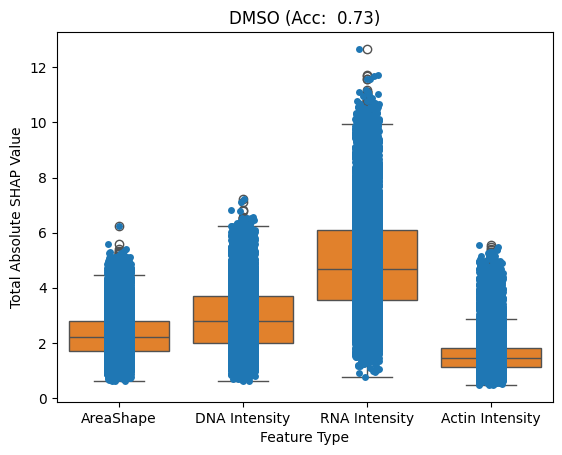

************KPT********
Accuracy is 0.28187080342671916
Confusion Matrix
[[ 2618  1637]
 [13871  3469]]
p-value: 1.0 over prior accuracy of 0.6835606019912016


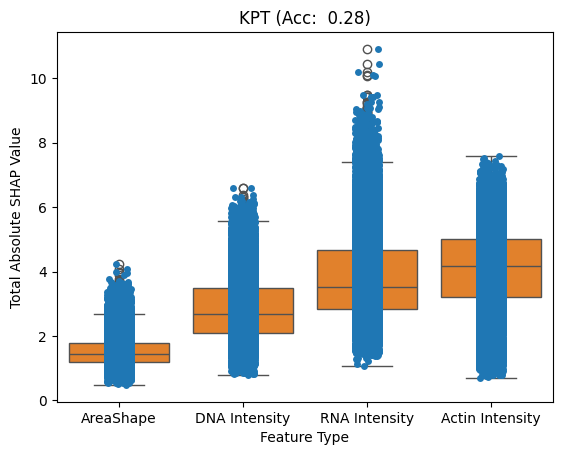

************H2O2********
Accuracy is 0.7166025288620121
Confusion Matrix
[[7585  788]
 [4367 5450]]
p-value: 0.0 over prior accuracy of 0.503149466739967


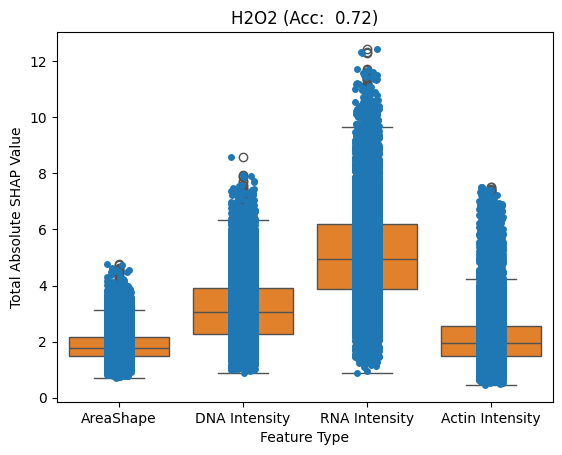

************Autophagy********
Accuracy is 0.7824519230769231
Confusion Matrix
[[5064  655]
 [2241 5352]]
p-value: 0.0 over prior accuracy of 0.5099587890625


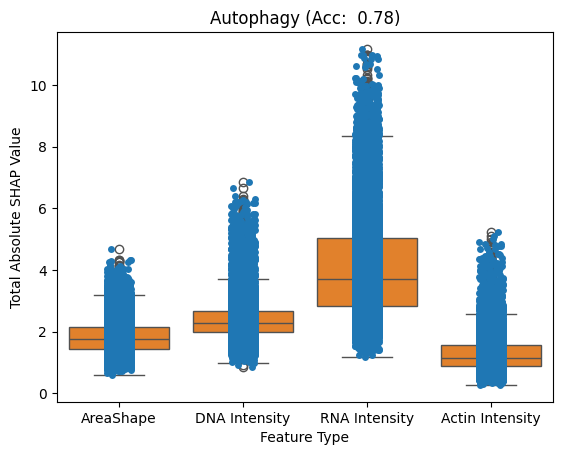

************Tunicamycin********
Accuracy is 0.7308696988322065
Confusion Matrix
[[4806  606]
 [2897 4707]]
p-value: 0.0 over prior accuracy of 0.5141739167178856


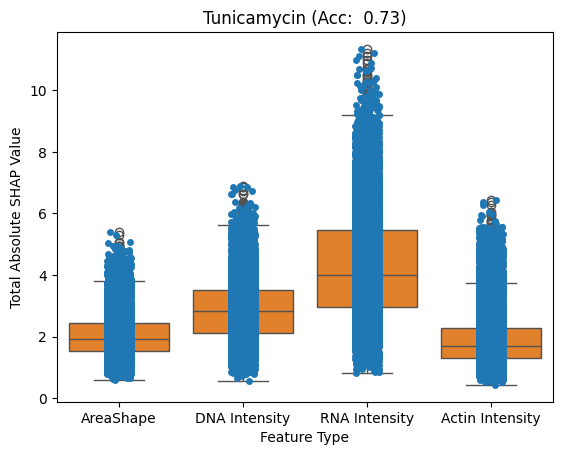

In [7]:
models = []
df_tests = []

for c in df["Condition"].unique():
    df_subsubset = df_subset[df_subset["Condition"] == c]
    #df_subset = df_subset[df_subset["ALS"] != 0]

    df_train = df_subsubset[df_subsubset["Test"] == 0]
    df_test = df_subsubset[df_subsubset["Test"] == 1]

    x_train = df_train[indep_columns]#.values
    #x_train = np.nan_to_num(x_train)
    y_train = df_train["ALS"].values

    x_test = df_test[indep_columns]#.values
    #x_test = np.nan_to_num(x_test)
    y_test = df_test["ALS"].values

    model = xgboost.XGBClassifier().fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    confusion_mat = confusion_matrix(y_test,y_pred)

    condition_name = condition_num_to_name(c)
    print(f"************{condition_name}********")
    print("Accuracy is",accuracy)
    print("Confusion Matrix")
    print(confusion_mat)



    marginals = np.sum(confusion_mat, axis=1)
    k = len(marginals)
    pvals = marginals / np.sum(marginals)#[1/float(k)] * k

    accs = []
    for iter in range(10000):
        rand_mat = []
        for marginal in marginals:
            row = np.random.multinomial(marginal, pvals = pvals)
            rand_mat.append(row)

        rand_mat = np.stack(rand_mat, axis=0)
        
        acc = np.sum(rand_mat.diagonal())/np.sum(rand_mat)
        accs.append(acc)

    accs = np.array(accs)
    pval = np.sum(accs >= accuracy)/len(accs)
    print(f"p-value: {pval} over prior accuracy of {np.mean(accs)}")

    models.append(model)
    df_tests.append(df_test)
    explainer = shap.Explainer(model)
    shap_values = explainer(x_test)
    data_shap = []
    data_type = []

    for feature_set_name, feature_set in zip(["AreaShape", "DNA Intensity", "RNA Intensity", "Actin Intensity"],[area_shape_indices, dna_indices, rna_indices, actin_indices]):
        mean_abs = np.sum(np.abs(shap_values.values[:,feature_set]), axis=1)
        data_shap += list(mean_abs)
        data_type += [feature_set_name]*len(mean_abs)

    df_shap = pd.DataFrame({"Total Absolute SHAP Value":data_shap, "Feature Type":data_type})
    sns.stripplot(df_shap, x="Feature Type", y="Total Absolute SHAP Value")
    sns.boxplot(df_shap, x="Feature Type", y="Total Absolute SHAP Value")
    plt.title(f"{condition_name} (Acc: {accuracy: .2f})")
    plt.show()

## Shap

In [16]:
condition = "H2O2"
cond_num = condition_num_to_name(condition, inverse=True)

model = models[cond_num]
df_test = df_tests[cond_num]
x_test = df_test[indep_columns]

explainer = shap.Explainer(model)
shap_values = explainer(x_test)

print(f"values: {shap_values.values.shape}, base_values: {shap_values.base_values.shape}, data: {shap_values.data.shape}")

values: (18190, 70), base_values: (18190,), data: (18190, 70)


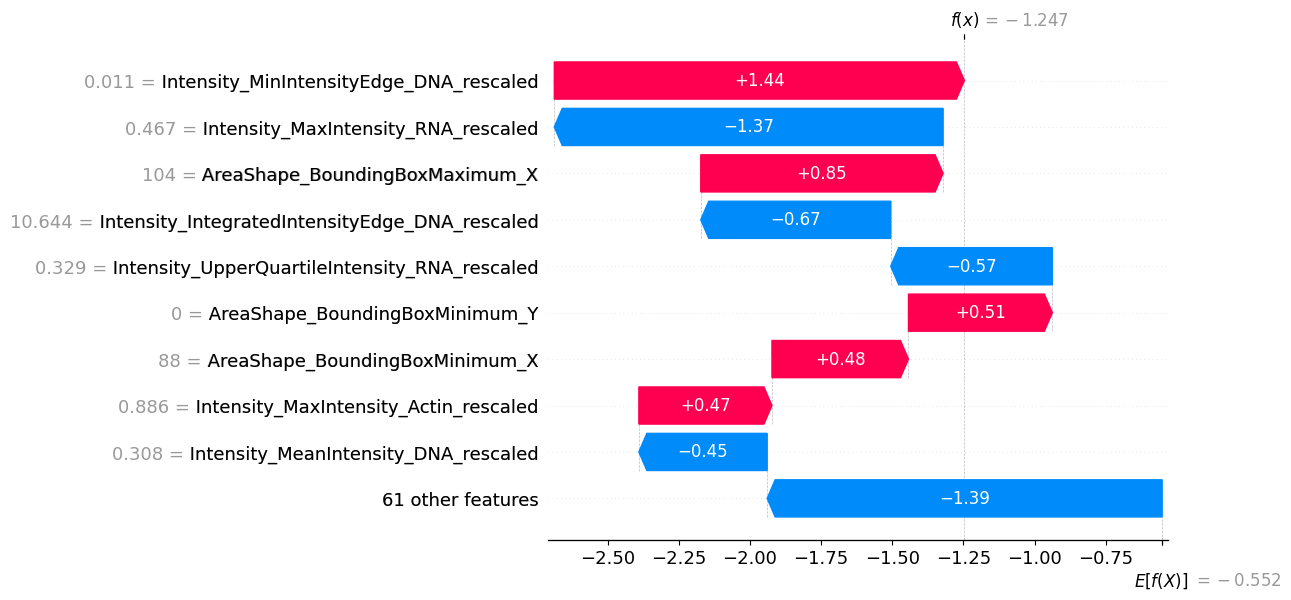

In [17]:
# # visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0,:])

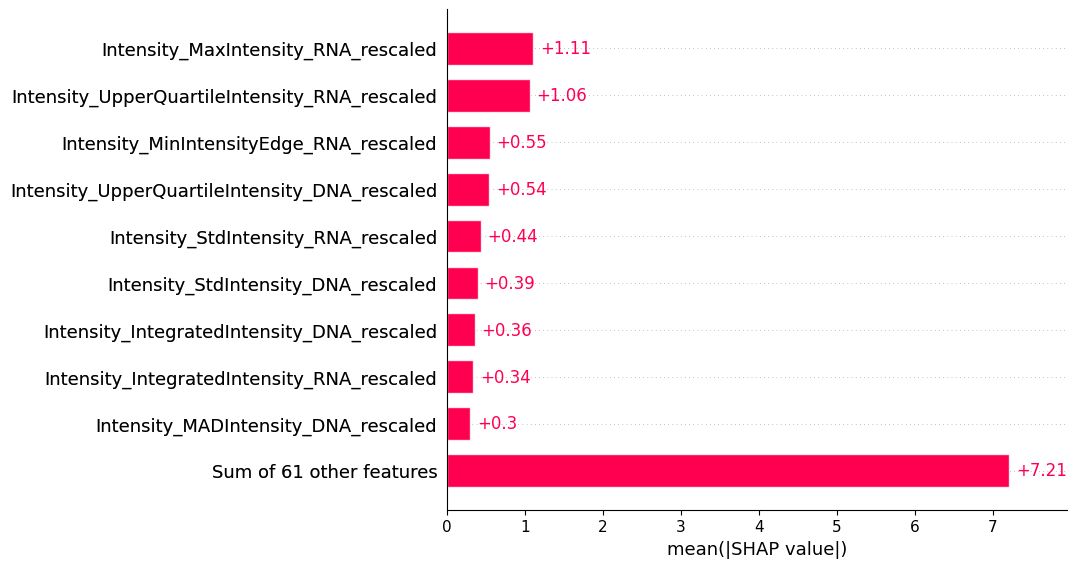

In [18]:
shap.plots.bar(shap_values)

<Axes: xlabel='Feature Type', ylabel='Total Absolute SHAP Value'>

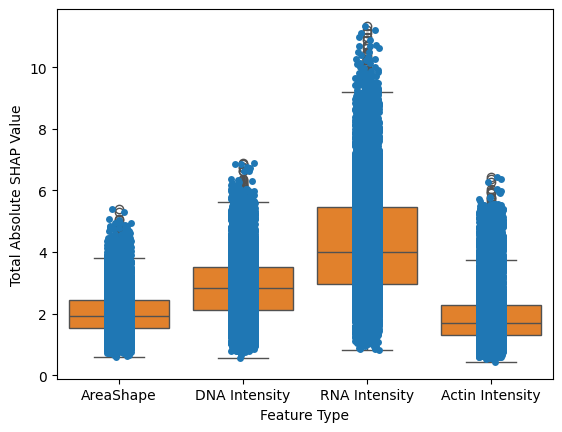

In [15]:
data_shap = []
data_type = []

for feature_set_name, feature_set in zip(["AreaShape", "DNA Intensity", "RNA Intensity", "Actin Intensity"],[area_shape_indices, dna_indices, rna_indices, actin_indices]):
    mean_abs = np.sum(np.abs(shap_values.values[:,feature_set]), axis=1)
    data_shap += list(mean_abs)
    data_type += [feature_set_name]*len(mean_abs)

df_shap = pd.DataFrame({"Total Absolute SHAP Value":data_shap, "Feature Type":data_type})
sns.stripplot(df_shap, x="Feature Type", y="Total Absolute SHAP Value")
sns.boxplot(df_shap, x="Feature Type", y="Total Absolute SHAP Value")

## View Image

In [78]:
# Get column number of IntensityMaxIntensity_RNA in x_test
col_num = x_test.columns.get_loc("Intensity_MaxIntensity_RNA")

col_vals = shap_values.values[:,col_num]
idxs = np.argsort(col_vals)

print(df_test.iloc[idxs[0]])

print(df_test.iloc[idxs[-1]])

AreaShape_Area                              586
AreaShape_BoundingBoxArea                  1269
AreaShape_BoundingBoxMaximum_X              211
AreaShape_BoundingBoxMaximum_Y              999
AreaShape_BoundingBoxMinimum_X              164
                                      ...      
Condition                                     4
Line                                    LJXiALS
FileName_ARD                      e4_wE9_f2.tif
ALS                                           0
Test                                          1
Name: 305483, Length: 75, dtype: object
AreaShape_Area                              439
AreaShape_BoundingBoxArea                   600
AreaShape_BoundingBoxMaximum_X              431
AreaShape_BoundingBoxMaximum_Y             1024
AreaShape_BoundingBoxMinimum_X              401
                                      ...      
Condition                                     4
Line                                    ZLMiALS
FileName_ARD                      e3_wC9_f1.tif


# Results

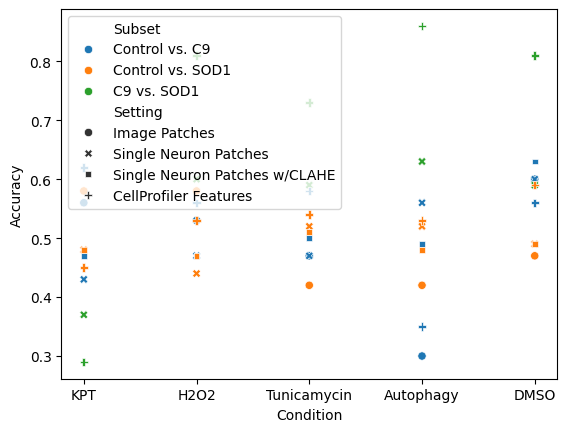

In [20]:
accs = [0.56, 0.53, 0.47, 0.3, 0.60, 0.58, 0.58, 0.42, 0.42, 0.47,
        0.43, 0.47, 0.47, 0.56, 0.60, 0.48, 0.44, 0.52, 0.52, 0.49,
        0.37, 0.6, 0.59, 0.63, 0.59,
        0.47, 0.47, 0.5, 0.49, 0.63, 0.48, 0.47, 0.51, 0.48, 0.49,
        0.62, 0.56, 0.58, 0.35, 0.56, 0.45, 0.53, 0.54, 0.53, 0.59,
        0.29, 0.81, 0.73, 0.86, 0.81]
conditions = ["KPT", "H2O2", "Tunicamycin", "Autophagy", "DMSO"] * 10
settings = ["Image Patches"] * 10 + ["Single Neuron Patches"] * 15 + ["Single Neuron Patches w/CLAHE"] * 10 \
+ ["CellProfiler Features"] * 15
subset = ((["Control vs. C9"] * 5 + ["Control vs. SOD1"] * 5) * 2 + ["C9 vs. SOD1"] * 5)*2

data = {"Accuracy": accs, "Setting": settings, "Subset": subset, "Condition": conditions}

df_results = pd.DataFrame(data)

sns.scatterplot(data=df_results, x="Condition", y="Accuracy", hue="Subset", style="Setting")
plt.savefig("/Users/thomasathey/Documents/shavit-lab/fraenkel/presentation/classification/scatter.svg")